# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

*Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.*

*Целевая метрика МАЕ <= 6.8*

*Краткое ознакомление с предметной областью [здесь](https://studbooks.net/1545514/tovarovedenie/ustroystvo_i_naznachenie_agregata_vnepechnoy_obrabotki_stali_tipa_pech-kovsh)*

## Исследовательский анализ данных и предобработка данных

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import datetime as dt
import lightgbm as lgb
import warnings
import time

import statsmodels.api as sm
from sklearn.inspection import permutation_importance
import shap


from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor, Pool


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

RANDOM_STATE=270323

In [7]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', sep=',')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', sep=',')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', sep=',')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv', sep=',')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', sep=',')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv', sep=',')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', sep=',')
except:
  print("что-то пошло не так")

### Изучение информации об электродах

In [8]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [9]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


* Данные по нагреву электродов представлены в полном объеме, пропуски отсутствуют;
* Данные позволяют нам посчитать сколько длился каждый нагрев - примерно несколько минут. Так же присутсвует схожий промежуток времени между циклами нагрева;
* Активная и реактивная мощность взаимосвязаны через полную мощность;
* Наиболее вероятно, что единца измерения активной мощности [МВт], а реактивной [МВар].

*Очень кратко (для понимания): активная мощность совершает полезную работу, а реактивная - греет подводящие провода, т.е. совершает вредную работу. Существуют потребители электроэнергии, у которых полная и активная мощности совпадают. Это потребители, у которых нагрузка представлена активными сопротивлениями (резисторами). Примерами подобной нагрузки являются лампы накаливания, электроплиты, жарочные шкафы и духовки, обогреватели, утюги, паяльники и пр.*

In [10]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Активная мощность не имеет сильных выбросов, в отличие от реактивной. Большая часть данных реактивной мощности находится в пределах 0,29 - 0,64 (1 и 3 квартили), но при этом имеется минимальное значение, равное -715.5 [МВар]. 

Рассмотрим более детально распределения активной и реактивной мощности:

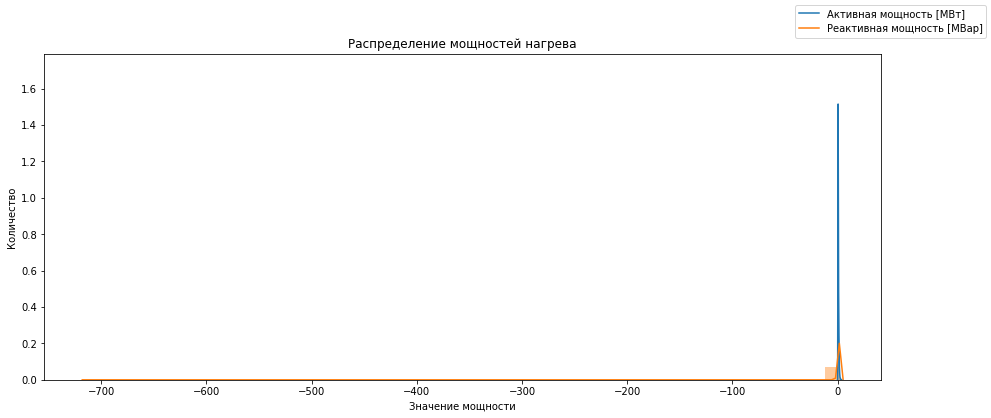

In [11]:
fig = plt.figure(figsize=(15,6))
sns.distplot(data_arc['Активная мощность'])
sns.distplot(data_arc['Реактивная мощность'])
plt.xlabel("Значение мощности")
plt.ylabel("Количество")
plt.title("Распределение мощностей нагрева")
fig.legend(labels=['Активная мощность [МВт]','Реактивная мощность [МВар]'])

Выбросы в реактивной мощности мешают детально посмотреть распределение мощностей. Посмотрим на данные выбросы - для этого выведем все значения реактивной мощности меньше 0.

In [12]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Найдена одна строка по партии 2116. Выведем всю информацию по данной партии.

In [13]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Скорей всего такое значение реактивной мощности является выбросом. Чтобы не терять данные по всей партии можем заменить выбор средним значением.

In [14]:
mean_r_power = data_arc[(data_arc['key'] == 2116) &
                        (data_arc['Реактивная мощность'] > 0)]['Реактивная мощность'].mean()
data_arc.loc[9780, 'Реактивная мощность'] = mean_r_power

Text(0.5, 1.0, 'Распределение мощностей нагрева')

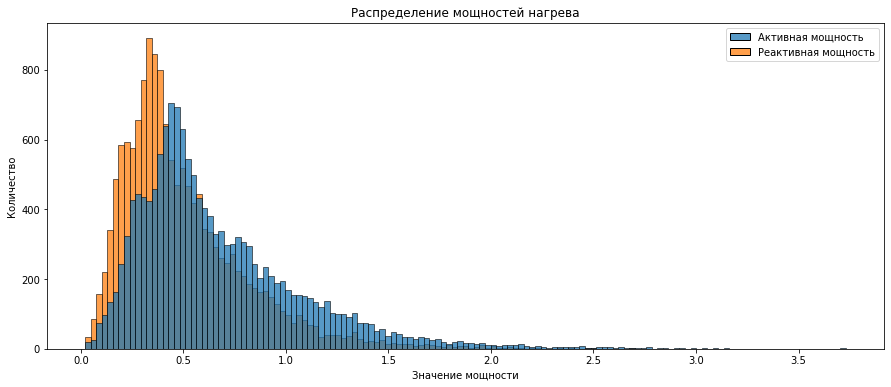

In [15]:
fig = plt.figure(figsize=(15,6))
sns.histplot(data_arc[['Активная мощность', 'Реактивная мощность']])
plt.xlabel("Значение мощности")
plt.ylabel("Количество")
plt.title("Распределение мощностей нагрева")

Теперь очевидно, что распределения мощностей очень похожи и имеют близкий к нормальному характер со скосом вправо.

Оценим насколько сильно данные значения зависят друг от друга.

In [16]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.9631812415341249

Получили коэффициент близкий к единице. Если оба этих столбца сделать признаками для будущей модели, то ее качество будет хуже, нежели если в нее включить всего одну мощность.
Есть 2 выхода:
1. Оставить только 1 признак
2. Объединить признаки в один - полную мощность, которая находится по формуле:

$$S = \sqrt{P^2 + R^2},$$

где *P* - активная мощность, <br>
*R* - реактивня мощность.

Добавим значение полной мощности.

In [17]:
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


Посмотрим количество партий в нашей выборке и номер последний партии:

In [18]:
len(data_arc['key'].value_counts())

3214

In [19]:
data_arc['key'].max()

3241

В выборке с нагревом электродов есть данные по 3214 партиям, хотя номер последний партии 3241. Можно сделать вывод, что по каким-то партиям данные не вошли в датасет, возможно они были забракованы. 

*В случае если это был брак, то он составил 0.0083%, что в массовом производстве может привести к экономическим потерям для произовдителя. В качестве будущего исследования, можно было бы предложить заказчику предоставить данные по всем бракованным партиям, возможно, что нам получилось бы установить неочевидные закономерности между временем нагрева стали/температурой/расходом энергии и браком.*

Вычислим сколько энергии было потрачено на нагрев. Для вычисления данного параметра нам нужно будет вычислить время нагрева в часах и умножить его на полную мощность, тогда мы получим затраченную энергию на каждый нагрев в МВА/ч. Для удобства переведём МВА/ч в КВА/ч, поскольку для таких коротких промежутков времени значения будут МВА/ч будут слишком малы.

In [20]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [21]:
data_arc['Время нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

In [22]:
data_arc['Время нагрева'] = data_arc['Время нагрева'].apply(lambda x: x.seconds)

In [23]:
data_arc['Затраченная энергия'] = data_arc['Полная мощность'] * 1000 * data_arc['Время нагрева'] / 3600

Добавим в качестве признака косинус угла сдвига фаз:

$$cos fi = P / S,$$

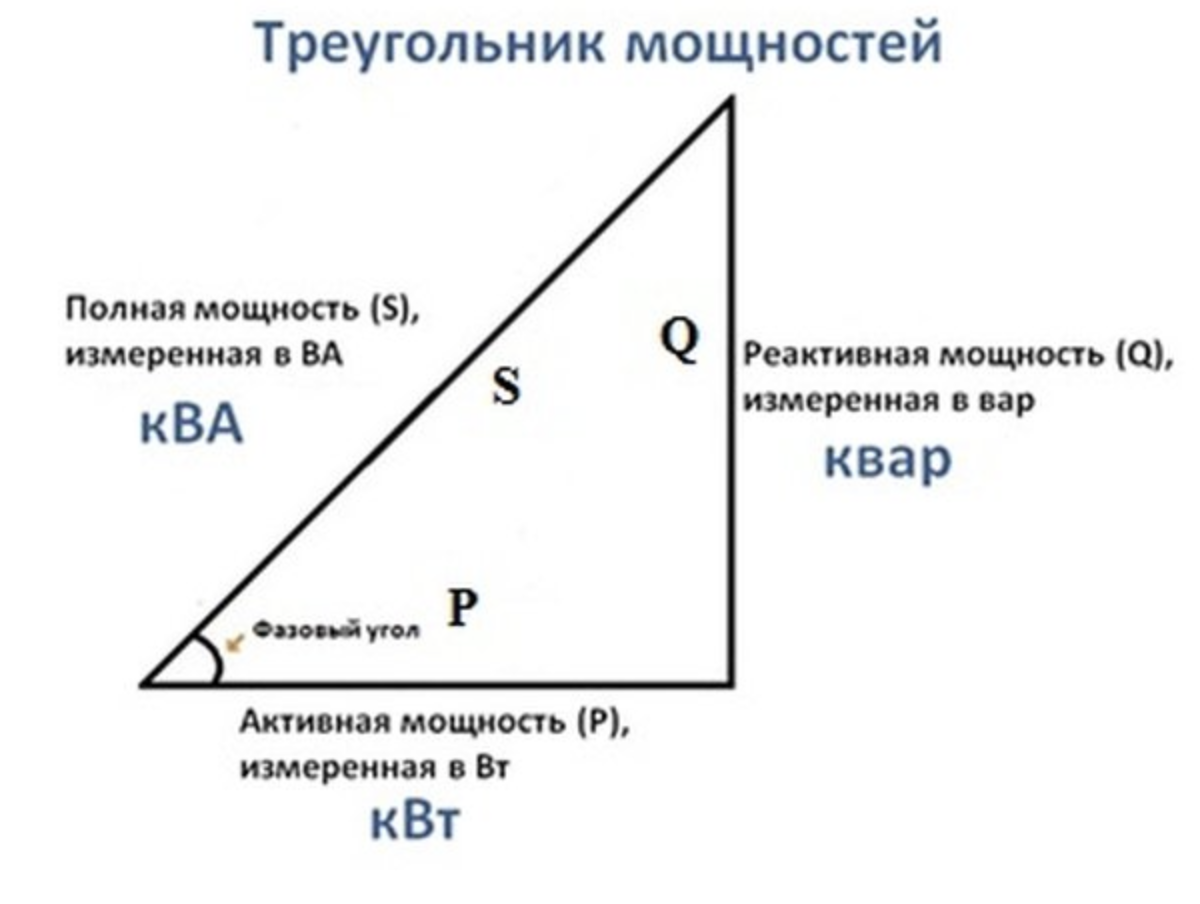

In [24]:
data_arc['Косинус фи'] = data_arc['Активная мощность'] / data_arc['Полная мощность']

In [25]:
data_arc.sample(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Затраченная энергия,Косинус фи
8935,1939,2019-07-16 20:51:54,2019-07-16 20:56:31,1.230278,0.851903,1.496437,277,115.142479,0.822139
13011,2829,2019-08-18 02:23:40,2019-08-18 02:26:11,0.518005,0.460870,0.693347,151,29.082067,0.747107
414,90,2019-05-06 12:35:27,2019-05-06 12:40:02,1.172704,0.891120,1.472865,275,112.510505,0.796206
10016,2170,2019-07-25 18:20:38,2019-07-25 18:25:12,1.204838,0.968973,1.546138,274,117.678279,0.779256
13434,2920,2019-08-21 10:55:11,2019-08-21 10:56:40,0.307018,0.180037,0.355912,89,8.798928,0.862623


In [26]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Затраченная энергия,Косинус фи
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.500710,0.838750,171.670946,53.640116,0.800888
std,934.571502,0.408159,0.310874,0.509840,98.186803,71.769528,0.042885
min,1.000000,0.030002,0.020806,0.036664,11.000000,0.112028,0.416389
25%,806.000000,0.395297,0.291008,0.495346,107.000000,14.864208,0.782598
50%,1617.000000,0.555517,0.415962,0.694922,147.000000,28.179013,0.808963
75%,2429.000000,0.857034,0.637371,1.066649,214.000000,63.161286,0.828697
max,3241.000000,3.731596,2.676388,4.592152,907.000000,1156.967181,0.889801


In [27]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
 5   Полная мощность       14876 non-null  float64       
 6   Время нагрева         14876 non-null  int64         
 7   Затраченная энергия   14876 non-null  float64       
 8   Косинус фи            14876 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 1.0 MB


Наша задача, заключается в том, чтобы спрогнозировать финальную температуру, которая в дальнейшем позволит уменьшить потребление электроэнергии на этапе обработки стали. Для этого полученные данные необходимо сгруппировать по партиями, где для каждой партии будет указан объем суммарной потребленной энергии. Суммарная потребленная энергия при этом покажет сколько энергетического ресурса понадобилось для доведения партии до оптимального химического состояния.

In [28]:
data_arc_batch = data_arc.groupby('key').agg({'Затраченная энергия': 'sum', 'Косинус фи': 'mean'}).reset_index()
data_arc_batch

,key,Затраченная энергия,Косинус фи
0,1,400.660487,0.837756
1,2,244.787101,0.840158
2,3,145.851882,0.845421
3,4,221.364253,0.841682
4,5,333.093877,0.828104
...,...,...,...
3209,3237,266.204510,0.809908
3210,3238,154.407603,0.781519
3211,3239,281.407700,0.830510
3212,3240,202.558039,0.776241


Получили сгруппированную табличку для каждой партии, проверим ее на примере 1 партии.

In [29]:
data_arc[data_arc['key'] == 1]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Затраченная энергия,Косинус фи
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228,75.597154,0.817717
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185,49.282440,0.840041
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172,42.810695,0.830728
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365,199.783720,0.842115
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148,33.186477,0.858178


Данные по 1 партии совпадают, группировка выполнена верно.

### Изучение информации о сыпучих материалах

In [30]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [31]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [32]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [33]:
len(data_bulk['key'].value_counts())

3129

In [34]:
data_bulk['key'].max()

3241

Из выведенной информации по добавленным сыпучим материалам можно заключить следующее:
1. Одна строка датасета представляет информацию по объему сыпучих материалов, добавленных в течение всего технологического процесса.
2. Состав добавления сыпучих материалов меняется в зависимости от того, когда партия достигает целевого химического сотава.
3. Пропуски в данных означают, что данная присадка не добавлялась для этой конкретной партии. Их можно заменить на 0.
4. Данные по присадкам так же представлены не по всем партиям, это следует учесть при составлении единого датасета со всеми данными.

Заполним пропуски и проверим на выбросы.

Text(0.5, 1.0, 'Диаграмма размаха для всех сыпучих материалов')

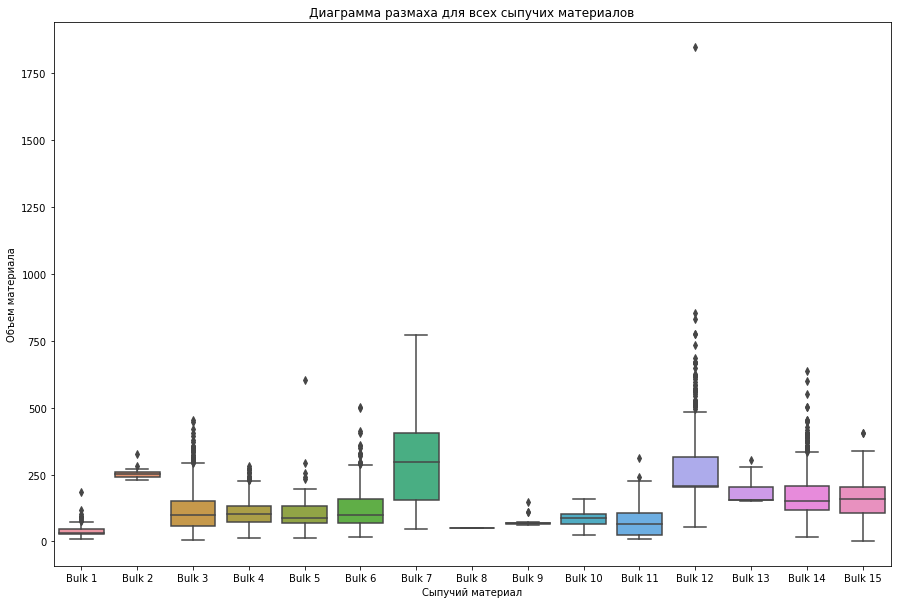

In [35]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data_bulk.drop('key', axis=1))
plt.xlabel("Сыпучий материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех сыпучих материалов")

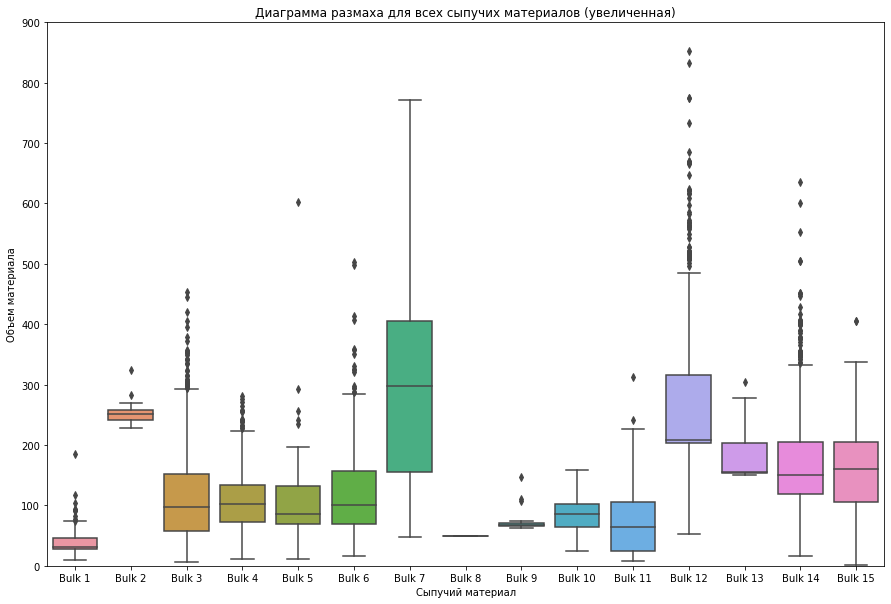

In [36]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data_bulk.drop('key', axis=1))
plt.xlabel("Сыпучий материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех сыпучих материалов (увеличенная)")
plt.ylim(0, 900)
plt.show()

Из диаграммы размаха видно, что существенные выбросы имеются только для присадок 5 и 12. Вполне возможно, что данные партии потребовали большее количество сыпучих материлов по сравнению со всеми остальными.

In [37]:
data_bulk = data_bulk.fillna(0)

In [38]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [39]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Мы изучили и обработали данные по объемам сыпучих материалов, они будут добавлены далее к общему датасету со всеми данными. 

Посмотрим на данные со временем добавления сыпучих материалов.

In [40]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [41]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [42]:
len(data_bulk_time['key'].value_counts())

3129

In [43]:
data_bulk_time['key'].max()

3241

**Вывод:** видим, что данные о времени добавления сыпучих материалов имеют ту же структуру, что и данные об объеме этих материалов. В рамках поставленной задачи, данные о времени в общий датасет включаться не будут. В нашем распоряжении есть время последнего добавления материалов по каждой партии.

### Изучение информации о продувке газом

In [44]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [45]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [46]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<AxesSubplot:xlabel='Газ 1', ylabel='Count'>

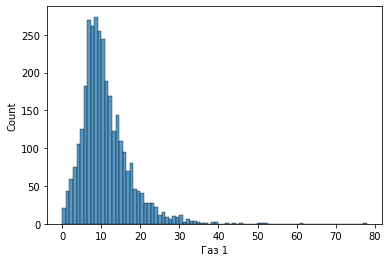

In [47]:
sns.histplot(data_gas['Газ 1'])

<AxesSubplot:xlabel='Газ 1'>

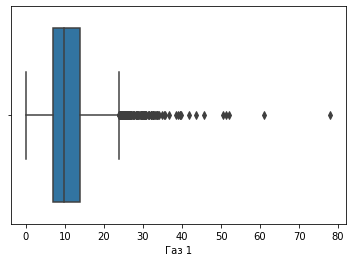

In [48]:
sns.boxplot(data_gas['Газ 1'])

In [49]:
len(data_gas['key'].unique())

3239

По добавляемому газу можно сказать следующее:
1. Газ добавляется в каждую партию - нулевые значения отсутствуют.
2. Объем газа имеет нормальное распределение немного скошенное вправо.
3. Пропуски в данных по газу отсутствуют, по количеству партий данный параметр заполнен наиболее полно по сравнению со всеми рассмотренными выше параметрами.

Данные по объему газа могут добавляться в общую таблицу без какой либо обработки.

### Изучение информации о проволочных материлах

Проведем исследование данных аналогично сыпучим материалам.

In [50]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [52]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [53]:
len(data_wire['key'].value_counts())

3081

In [54]:
data_wire['key'].max()

3241

Text(0.5, 1.0, 'Диаграмма размаха для всех проволочных материалов')

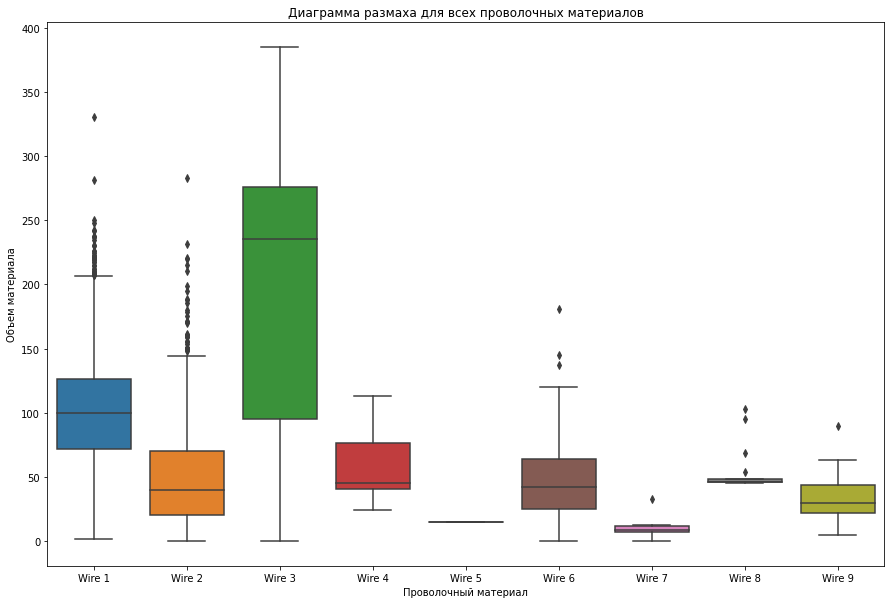

In [55]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data_wire.drop('key', axis=1))
plt.xlabel("Проволочный материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех проволочных материалов")

Анализ данных по объему проволочных материалов показал:
1. По аналогии с сыпучими материалами объем материалов отличается в зависимости от партии.
2. Пропуски в данных в каком либо столбце означают отсутствие добавления этого материала для этой партии, поэтому также могут быть заменены нулями, как в случае с сыпучими материалами.
3. Добавление в партию сильно завичит от номера проволочного материала. Так материал №5 добавлялся всего в одну 1 партий. Выбросы могут быть обусловлены просто небольшим количеством данных по данному материалу.

In [56]:
data_wire = data_wire.fillna(0)

In [57]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Данные об объемах проволочных материалов рассмотрены, посмотрим на данные о времени их добавления.

In [59]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Видим, что данные о времени добавления проволочных материалов идентичны по структуре данным с объемами материалов.
Аналогично сыпучим материалам данные о времени в общий датасет не добавляем, следовательно и не обрабатываем.

### Изучение данных о температуре

In [61]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [62]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [63]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Text(0.5, 1.0, 'Распределение замеров температуры')

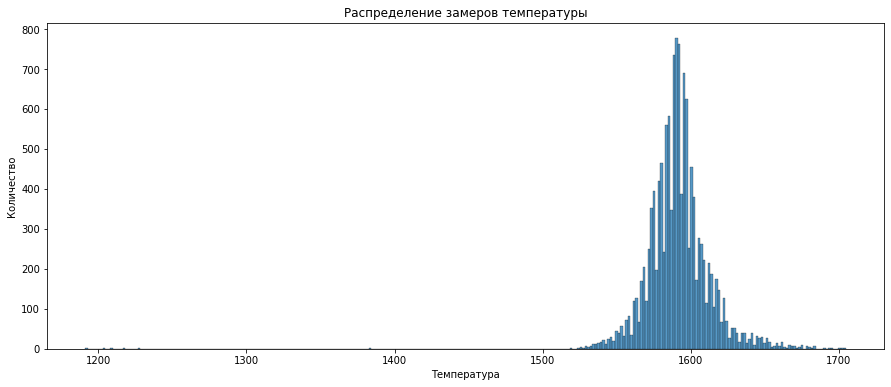

In [64]:
fig = plt.figure(figsize=(15,6))
sns.histplot(data_temp['Температура'].dropna())
plt.xlabel('Температура')
plt.ylabel("Количество")
plt.title("Распределение замеров температуры")

Text(0.5, 1.0, 'Диаграмма размаха температуры плавления')

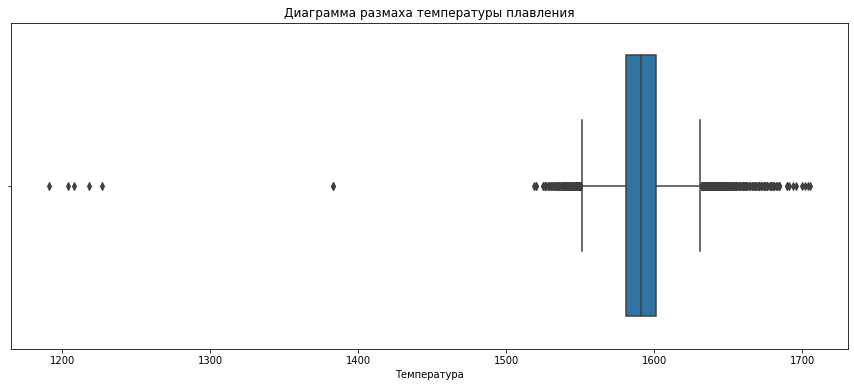

In [65]:
fig = plt.figure(figsize=(15,6))
sns.boxplot(data_temp['Температура'])
plt.xlabel('Температура')
plt.title("Диаграмма размаха температуры плавления")

In [66]:
data_temp[data_temp['Температура'].isna()].head(10)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


In [67]:
data_temp[data_temp['key'] == 2502]

,key,Время замера,Температура
12276,2502,2019-08-06 04:45:26,1583.0
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN
12280,2502,2019-08-06 05:04:16,NaN
12281,2502,2019-08-06 05:11:38,NaN
12282,2502,2019-08-06 05:12:20,NaN


Разберемся, что удалось выявить из выведенных по темперутаре данных:
1. Почти для трёх тысяч строк данные пропущены, несмотря на то, что указано время замера. Нужно проверить количество измерений по каждой партии.
2. Диаграммы распределения и размаха показали, что все измерения меньше 1500 градусов можно отнести к выбросам, поскольку из от заказчика известно, что температура плавления стали выше 1500 градусов Цельсия. В связи с этим все данные, где температура стали меньше 1500 градусов могут быть отнесены к ошибочным и удалены из датасета о температуре.

План по обработке датасета с температурой:
* убираем значения меньше 1500
* переводим столбец с временем в формат datetime
* сортируем по партии и времени
* делаем группировку с выбором первого и последнего значения для группы
* избавляемся от партий где всего 1 измерение

In [68]:
data_temp = data_temp.dropna()

Text(0.5, 1.0, 'Диаграмма размаха температуры плавления')

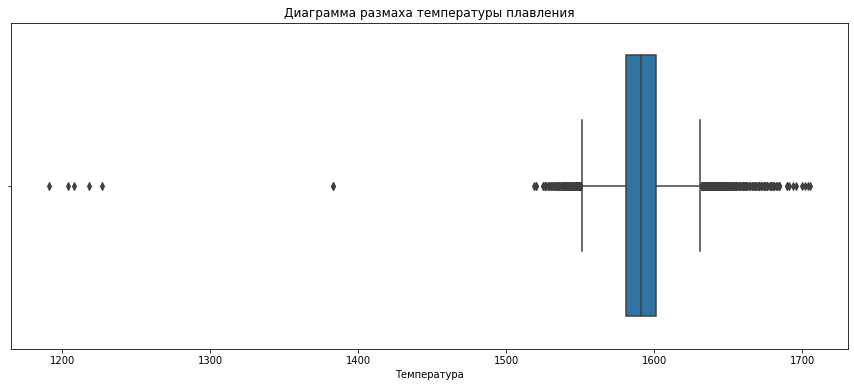

In [69]:
fig = plt.figure(figsize=(15,6))
sns.boxplot(data_temp['Температура'])
plt.xlabel('Температура')
plt.title("Диаграмма размаха температуры плавления")

Теперь данные рспределены нормально.

In [70]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [71]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


In [72]:
data_temp = data_temp.sort_values(by=['key', 'Время замера'])
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


**ВОПРОСЫ:**

1. Как лучше обработать температурный датасет?
2. Уточнить у заказчика температуру плавления используемой стали?
3. В представленной заказчиком информации отсутствуют критерии для оценки работоспособности будующей модели, какой именно точности предсказания хочет добиться заказчик?


**ПЛАН РАБОТЫ:**
1. Проводим изучение информации в каждом датасете. Производим обработку данных: приводим их к рабочему виду.
2. Объединяем датасеты в один. Составляем новые признаки.
3. Делим выборку на трейн и тест в соотношении 75 на 25. Проводим масштабирование данных.
4. Обучаем модели с поиском оптимальных параметров с помощью GridSearchCV. Для обучения воспользуемся следующими алгоритмами: линейная регрессия, случайный лес, LightGBM, Сatboost.
5. Проверяем работу моделей. В качестве метрики используем MAE.
6. Составляем технический отчёт.



**ЦЕЛЬ ПРОЕКТА:**
Построить модель, которая предскажет температуру стали.
Целевым признаком будет измеренная температура.

*По дополнительной информации, полученной от заказчика: партии, где известна всего одна температура не должны браться для моделирования, т.к. не отражают реальной картины. Для партий, где измерения полные, будем оставлять начльную температуру в качестве обучающего признака и последнюю температуру в качестве таргета.*

Данные по температуре отсортированы, сделаем группировку с подсчетом количества и выборкой первого и последнего значений.

In [73]:
df = data_temp.groupby('key').agg({'Температура': ['count', 'first', 'last']}).reset_index()
df

key Температура                
                 count   first    last
0        1           5  1571.0  1613.0
1        2           6  1581.0  1602.0
2        3           5  1596.0  1599.0
3        4           3  1601.0  1625.0
4        5           2  1576.0  1602.0
...    ...         ...     ...     ...
3211  3237           1  1569.0  1569.0
3212  3238           1  1584.0  1584.0
3213  3239           1  1598.0  1598.0
3214  3240           1  1617.0  1617.0
3215  3241           1  1586.0  1586.0

[3216 rows x 4 columns]

Проверку на примере партии 7.

In [74]:
data_temp[data_temp['key'] == 7]

,key,Время замера,Температура
26,7,2019-05-03 14:19:43,1586.0
27,7,2019-05-03 14:20:19,1582.0
28,7,2019-05-03 14:32:07,1599.0
29,7,2019-05-03 14:38:48,1595.0
30,7,2019-05-03 14:42:37,1599.0


Группировка прошла верно, зададим корректное название столбцов:

In [75]:
df.columns = ['key', 'Количество замеров по температуре', 
              'Температура начальная', 'Температура конечная']

In [76]:
df

,key,Количество замеров по температуре,Температура начальная,Температура конечная
0,1,5,1571.0,1613.0
1,2,6,1581.0,1602.0
2,3,5,1596.0,1599.0
3,4,3,1601.0,1625.0
4,5,2,1576.0,1602.0
...,...,...,...,...
3211,3237,1,1569.0,1569.0
3212,3238,1,1584.0,1584.0
3213,3239,1,1598.0,1598.0
3214,3240,1,1617.0,1617.0


Избавимся от партий, где всего 1 замер.

In [77]:
df = df[df['Температура начальная'] >= 1500]

In [78]:
df = df[df['Температура конечная'] >= 1500]

In [79]:
df = df[df['Количество замеров по температуре'] > 1]

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2476
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   key                                2471 non-null   int64  
 1   Количество замеров по температуре  2471 non-null   int64  
 2   Температура начальная              2471 non-null   float64
 3   Температура конечная               2471 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 96.5 KB


Данные по температуре подготовлены.

### Создание единого датасета со всеми данными

Определяющим параметром для создания единого датасетя является наличие температуры, поэтому последний полученный датасет df является ключевым, к нему будем присоединять все остальные. Если в других датасетах есть информация о партиях, по которым у нас нет измеренной температуры, то такую информацию добавлять нецелесообразно.

Посчитаем количество партий с известной температурой:

In [81]:
len(df['key'].unique())

2471

In [82]:
df = df.merge(data_arc_batch, on=['key'], how='left')
df = df.merge(data_bulk, on=['key'], how='left')
df = df.merge(data_gas, on=['key'], how='left')
df = df.merge(data_wire, on=['key'], how='left')

In [83]:
df.head(10)

,key,Количество замеров по температуре,Температура начальная,Температура конечная,Затраченная энергия,Косинус фи,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,1571.0,1613.0,400.660487,0.837756,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,6,1581.0,1602.0,244.787101,0.840158,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,1596.0,1599.0,145.851882,0.845421,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3,1601.0,1625.0,221.364253,0.841682,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,1576.0,1602.0,333.093877,0.828104,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,5,1543.0,1596.0,391.874227,0.830749,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,5,1586.0,1599.0,202.716842,0.852187,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,4,1577.0,1598.0,430.706174,0.826999,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,5,1587.0,1592.0,112.905735,0.816653,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,8,1574.0,1593.0,171.489307,0.772935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,6.529891,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2470
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   key                                2471 non-null   int64  
 1   Количество замеров по температуре  2471 non-null   int64  
 2   Температура начальная              2471 non-null   float64
 3   Температура конечная               2471 non-null   float64
 4   Затраченная энергия                2471 non-null   float64
 5   Косинус фи                         2471 non-null   float64
 6   Bulk 1                             2403 non-null   float64
 7   Bulk 2                             2403 non-null   float64
 8   Bulk 3                             2403 non-null   float64
 9   Bulk 4                             2403 non-null   float64
 10  Bulk 5                             2403 non-null   float64
 11  Bulk 6                             2403 non-null   float

После объединения данных, мы видим, что больше всего в наличии информации по партиям с известной температурой было в датасетах с газом и нагревом (2475 для энергии и 2473 для газа) и меньше по присадкам - для сыпучих 2407, для проволочных 2372.

Исключим из датасета те партии, по которым не было данных:

In [85]:
df = df.dropna()

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2470
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   key                                2325 non-null   int64  
 1   Количество замеров по температуре  2325 non-null   int64  
 2   Температура начальная              2325 non-null   float64
 3   Температура конечная               2325 non-null   float64
 4   Затраченная энергия                2325 non-null   float64
 5   Косинус фи                         2325 non-null   float64
 6   Bulk 1                             2325 non-null   float64
 7   Bulk 2                             2325 non-null   float64
 8   Bulk 3                             2325 non-null   float64
 9   Bulk 4                             2325 non-null   float64
 10  Bulk 5                             2325 non-null   float64
 11  Bulk 6                             2325 non-null   float

В конечном итоге мы имеем в распоряжении 2329 партии для дальнейшего обучения машинного обучения и прогнозирования конечной температуры.

## Обучение моделей машинного обучения

**План обучения моделей машинного обучения:**

1. Исключаем из датасета данные по номеру партии и количеству замеров по температуре.
2. Делим выборку на train и test в соотношении 75 на 25.
3. Проводим масштабирование данных с помощью StandardScaler.
4. Обучаем модели с поиском оптимальных параметров с помощью GridSearchCV. 

**Для обучения воспользуемся следующими алгоритмами:**

* Линейная регрессия
* Случайный лес
* LightGBM
* Сatboost

###  Подготовка выборок для обучения

Для начала посмотрим на описательные статистики получившегося набора данных.

In [87]:
df.describe()

,key,Количество замеров по температуре,Температура начальная,Температура конечная,Затраченная энергия,Косинус фи,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,4.979355,1587.365161,1593.366022,251.002285,0.801379,3.433548,1.424946,47.296774,37.331613,2.644731,22.468817,2.008172,0.021075,0.445591,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,11.378942,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658
std,715.099053,1.783821,23.623144,11.209581,180.840911,0.032203,12.421994,19.098442,75.228262,58.670377,22.421296,55.831097,30.702509,1.016213,6.225965,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,6.395632,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510
min,1.000000,2.000000,1519.000000,1541.000000,4.210582,0.552784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,629.000000,4.000000,1571.000000,1587.000000,129.232078,0.789938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,5.000000,1587.000000,1593.000000,213.284900,0.806929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,6.000000,1603.000000,1598.000000,323.989913,0.820589,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,14.217691,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,16.000000,1660.000000,1653.000000,2953.050186,0.869155,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


В признаке wire 5 остались только нулевые значения, следовательно в полученные партии данный проволочный материал не добавлялся. Также в данной операции сразу удалим данные по номеру партий и количество измерений температуры, проведенных для них.

In [88]:
df = df.drop(['key', 'Количество замеров по температуре', 'Wire 5'], axis=1)

In [89]:
df.head()

,Температура начальная,Температура конечная,Затраченная энергия,Косинус фи,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,400.660487,0.837756,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,244.787101,0.840158,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,145.851882,0.845421,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,221.364253,0.841682,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,333.093877,0.828104,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


Проверим наши данные на мультиколлинеарность:

<AxesSubplot:>

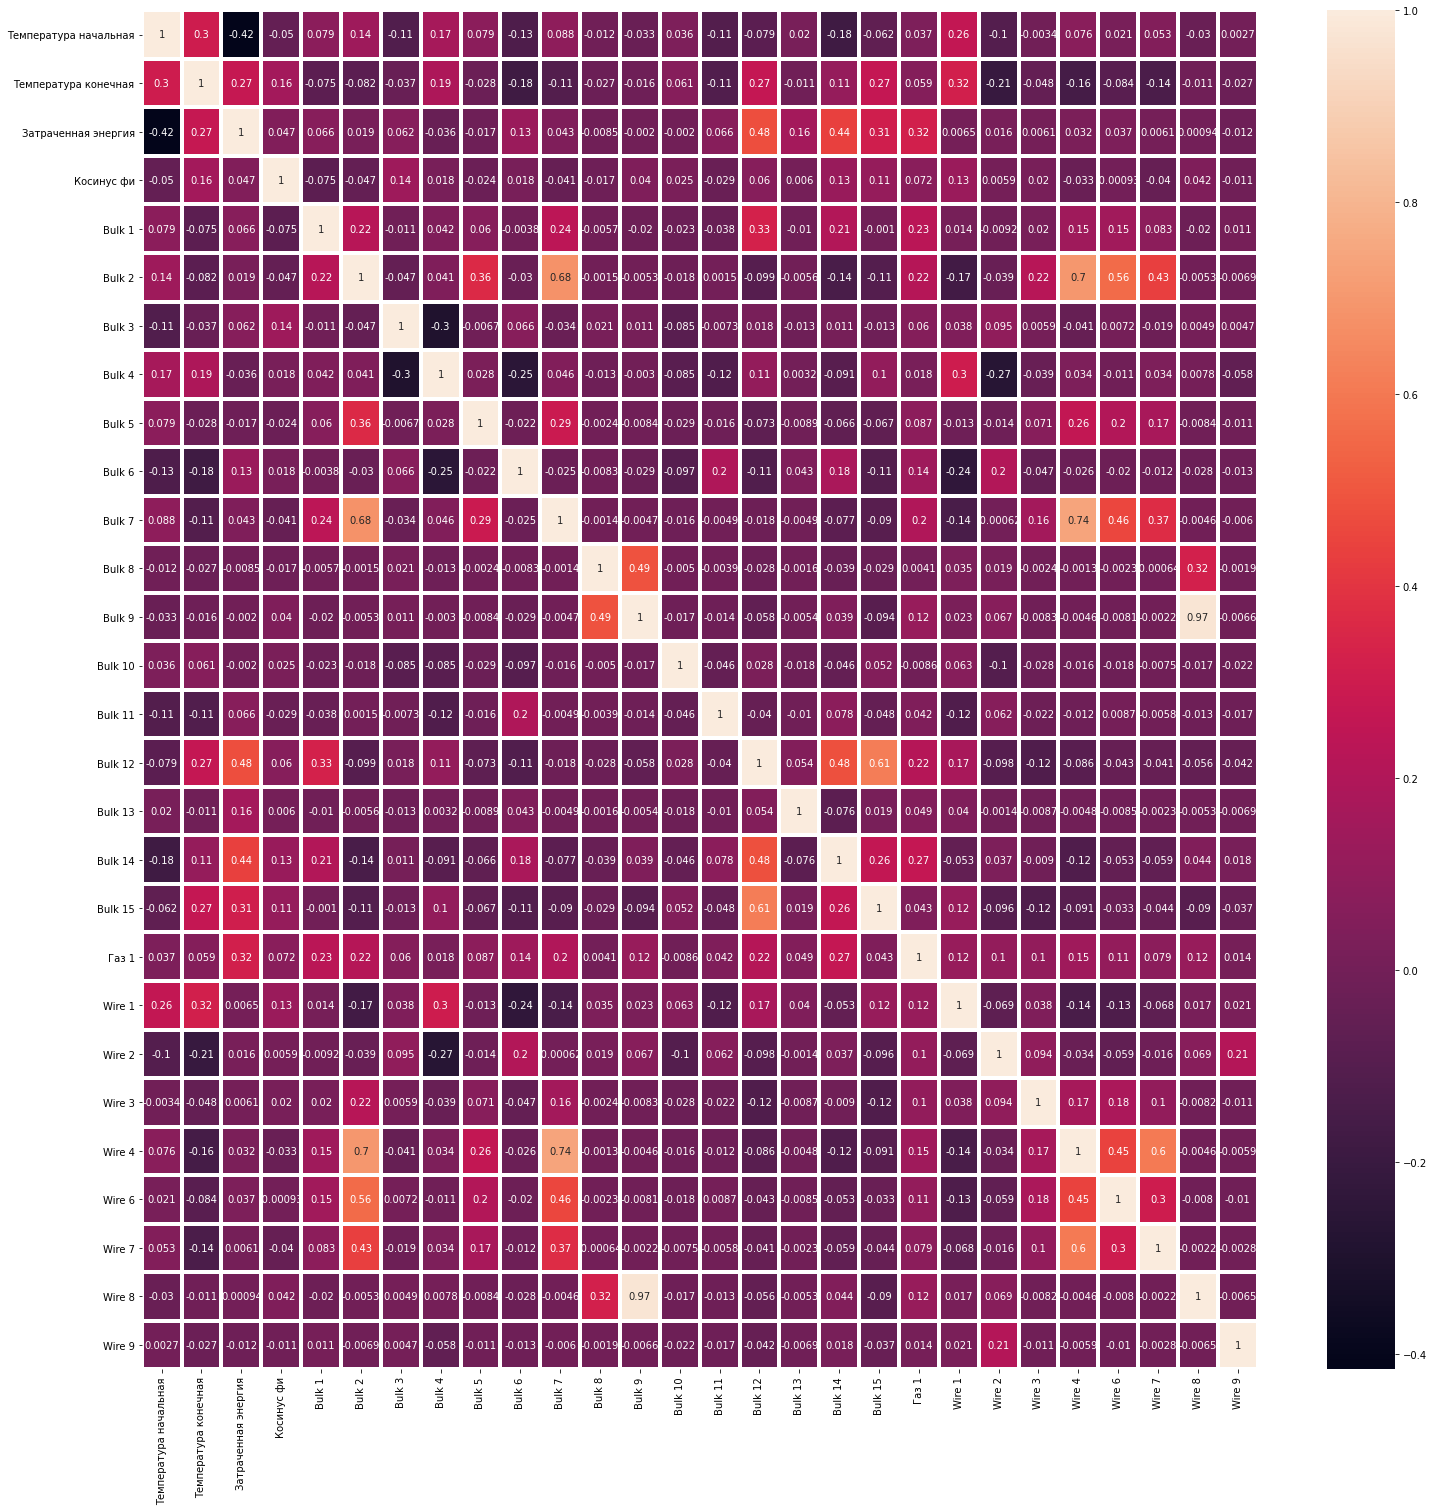

In [90]:
plt.rcParams['figure.figsize'] = (25, 25)
sns.heatmap(df.corr(), annot=True, linewidths=3, linecolor='white')

Heatmap получился перегруженный, его сложно анализировать. Найдем только те параметры, у которых корреляция превышает 0,9 по модулю.

In [91]:
corr_table = df.corr().unstack().sort_values().drop_duplicates()

corr_table[(corr_table > 0.9) | (corr_table < -0.9)]

Wire 8                 Bulk 9                   0.974968
Температура начальная  Температура начальная    1.000000
dtype: float64

Выявлена весьма высокая корреляция между признаками Bulk 9 и Wire 8. Возможно такая корреляция между этими добавками вызвана тем, что они добавляются попарно. Один из признаков необходимо исключить из датасета, иначе это может ухудшить результаты работы модели:

In [92]:
df = df.drop('Bulk 9', axis=1)

Приведём название столбцов к единому зеимному_регистру, а так же перименуем на английский язык, потому что некоторые алгоритмы не воспринимают русский текст:

In [93]:
df = df.rename(columns={'Температура начальная': 'start_temp', 
                        'Температура конечная': 'final_temp', 
                       'Затраченная энергия':'energy',
                       'Косинус фи':'cos_fi',
                       'Газ 1': 'gas'})

In [94]:
df.describe()

,start_temp,final_temp,energy,cos_fi,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1587.365161,1593.366022,251.002285,0.801379,3.433548,1.424946,47.296774,37.331613,2.644731,22.468817,2.008172,0.021075,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,11.378942,102.412198,17.605637,3.240481,0.307077,0.980504,0.006371,0.311847,0.317658
std,23.623144,11.209581,180.840911,0.032203,12.421994,19.098442,75.228262,58.670377,22.421296,55.831097,30.702509,1.016213,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,6.395632,43.535263,33.642919,27.966585,4.761821,8.700682,0.205882,4.406475,3.459510
min,1519.000000,1541.000000,4.210582,0.552784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,129.232078,0.789938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,73.207679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1587.000000,1593.000000,213.284900,0.806929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,101.087998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1603.000000,1598.000000,323.989913,0.820589,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,14.217691,128.069763,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1660.000000,1653.000000,2953.050186,0.869155,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600


Получим train и test выборки. Валидационную выборку не выделяем, т.к. будем применять кросс-валидацию внутри GridSearchCV.

In [95]:
target = df['final_temp']
features = df.drop('final_temp', axis=1)
    
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=RANDOM_STATE)

In [96]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1743, 26)
(582, 26)
(1743,)
(582,)


Выборки получены, проведем масштабирование данных с помощью StandardScaler.

In [97]:
scaler = StandardScaler()
scaler.fit(features_train)
    
features_train_scaler = scaler.transform(features_train)
features_test_scaler = scaler.transform(features_test)

In [98]:
features_train.describe()

,start_temp,energy,cos_fi,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000
mean,1587.754446,250.817682,0.801985,3.227768,1.476764,48.583477,38.503729,2.709122,23.869765,1.617326,0.028112,5.117040,4.337349,207.866322,1.044177,153.687321,119.537005,11.400941,102.098712,17.616965,2.922934,0.260726,0.903209,0.005610,0.224682,0.322671
std,23.499382,177.875041,0.030967,11.455815,19.556078,76.370726,59.284752,23.745947,57.417646,29.461565,1.173674,20.972867,22.707894,154.795832,13.408738,81.575244,84.769497,6.248347,44.025908,34.045968,25.818155,3.972480,7.750561,0.204978,3.716595,3.296855
min,1519.000000,4.580216,0.552784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,127.989504,0.790212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.500000,0.000000,7.349273,71.825517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1587.000000,211.600728,0.807291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.177886,100.198799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1603.000000,322.160795,0.820730,0.000000,0.000000,82.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,291.000000,0.000000,204.000000,204.000000,14.219637,128.194564,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1660.000000,1426.229920,0.869155,92.000000,325.000000,421.000000,281.000000,603.000000,503.000000,772.000000,49.000000,154.000000,313.000000,833.000000,278.000000,450.000000,337.000000,52.142373,330.314424,282.780152,288.432144,92.570401,145.139283,8.490040,95.244248,53.071201


In [99]:
features_test.describe()

,start_temp,energy,cos_fi,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.0,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,1586.199313,251.555141,0.799563,4.049828,1.269759,43.443299,33.821306,2.451890,18.273196,3.178694,0.0,4.895189,3.998282,210.429553,1.144330,154.823024,121.493127,11.313058,103.351039,17.571711,4.191487,0.445894,1.211991,0.008652,0.572890,0.302645
std,23.972549,189.602740,0.035617,14.941052,17.672223,71.623317,56.695603,17.893265,50.598816,34.150961,0.0,20.837235,22.022950,164.074081,16.518277,80.929356,84.444622,6.822927,42.054645,32.434453,33.596531,6.584785,11.073649,0.208727,6.013451,3.909409
min,1526.000000,4.210582,0.559403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1569.250000,134.966006,0.789210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,105.250000,0.000000,104.250000,0.000000,7.150207,77.783160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1585.000000,220.784006,0.806112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,205.000000,0.000000,149.000000,107.000000,9.873411,103.030201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1602.000000,327.324432,0.820114,0.000000,0.000000,72.750000,67.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,259.750000,0.000000,204.000000,204.000000,14.135782,126.923156,21.767978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1658.000000,2953.050186,0.855744,185.000000,258.000000,454.000000,258.000000,256.000000,407.000000,553.000000,0.0,159.000000,242.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,241.300813,231.568481,385.008668,113.231044,180.454575,5.035472,102.762401,62.025600


Масштабирование признаков проведено успешно.

### Обучение моделей

Определять оптимальные параметры для каждой модели будем с помощью GridSearchCV. Возьмем 5 фолдов для кросс-валидации, в качестве скорера используем "neg_mean_absolute_error".

**Обучим следующие модели:**
* LinearRegression
* RandomForestRegressor
* LGBMRegressor
* CatBoostRegressor

Cоздадим функцию mae_score для скора:

In [95]:
def mae_score (target, predictions):
    mae = mean_absolute_error(target, predictions)
    return mae
scorer = make_scorer(mae_score, greater_is_better=False)

####  Линейная регрессия

In [96]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
grid.fit(features_train_scaler, target_train)
print("MAE линейной регрессии составляет ", -grid.best_score_)
print('Наилучшие подобранные параметры для линейной регрессии')
grid.best_params_

'model = LinearRegression()\nparameters = {\'fit_intercept\':[True,False], \'normalize\':[True,False]}\ngrid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)\ngrid.fit(features_train_scaler, target_train)\nprint("MAE линейной регрессии составляет ", -grid.best_score_)\nprint(\'Наилучшие подобранные параметры для линейной регрессии\')\ngrid.best_params_'

MAE линейной регрессии составляет  6.927<br>
Наилучшие подобранные параметры для линейной регрессии: {'fit_intercept': True, 'normalize': True}

#### Случайный лес

In [97]:
forest = RandomForestRegressor(random_state=RANDOM_STATE)
    
forest_params = {'n_estimators': range(30, 81, 10),
                 'max_depth': range(1,12)}

forest_grid = GridSearchCV(forest, forest_params,
                         cv=5, verbose=5, scoring=scorer)

forest_grid.fit(features_train, target_train)

print("MAE для случайного леса составляет ", -forest_grid.best_score_)


print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
[CV 1/5] END .....max_depth=1, n_estimators=30;, score=-7.476 total time=   0.0s
[CV 2/5] END .....max_depth=1, n_estimators=30;, score=-7.756 total time=   0.0s
[CV 3/5] END .....max_depth=1, n_estimators=30;, score=-7.572 total time=   0.0s
[CV 4/5] END .....max_depth=1, n_estimators=30;, score=-8.117 total time=   0.0s
[CV 5/5] END .....max_depth=1, n_estimators=30;, score=-8.247 total time=   0.0s
[CV 1/5] END .....max_depth=1, n_estimators=40;, score=-7.428 total time=   0.0s
[CV 2/5] END .....max_depth=1, n_estimators=40;, score=-7.756 total time=   0.0s
[CV 3/5] END .....max_depth=1, n_estimators=40;, score=-7.582 total time=   0.0s
[CV 4/5] END .....max_depth=1, n_estimators=40;, score=-8.131 total time=   0.0s
[CV 5/5] END .....max_depth=1, n_estimators=40;, score=-8.249 total time=   0.0s
[CV 1/5] END .....max_depth=1, n_estimators=50;, score=-7.437 total time=   0.1s
[CV 2/5] END .....max_depth=1, n_estimators=50;

MAE для случайного леса составляет  6.2896 <br>
Наилучшие подобранные параметры для случайного леса<br>
{'max_depth': 10, 'n_estimators': 80}

#### Light GBM

In [98]:
gbm = LGBMRegressor(random_state=RANDOM_STATE)
    
g_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = GridSearchCV(gbm, g_params,
                         cv=5, verbose=5, scoring=scorer)

g_grid.fit(features_train, target_train)

print("MAE для LGBM составляет ", -g_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50, num_leaves=21;, score=-6.825 total time=   0.0s
[CV 2/5] END learning_rate=0.01, n_estimators=50, num_leaves=21;, score=-7.276 total time=   0.0s
[CV 3/5] END learning_rate=0.01, n_estimators=50, num_leaves=21;, score=-7.167 total time=   0.0s
[CV 4/5] END learning_rate=0.01, n_estimators=50, num_leaves=21;, score=-7.500 total time=   0.0s
[CV 5/5] END learning_rate=0.01, n_estimators=50, num_leaves=21;, score=-7.715 total time=   0.0s
[CV 1/5] END learning_rate=0.01, n_estimators=50, num_leaves=31;, score=-6.777 total time=   0.1s
[CV 2/5] END learning_rate=0.01, n_estimators=50, num_leaves=31;, score=-7.234 total time=   0.0s
[CV 3/5] END learning_rate=0.01, n_estimators=50, num_leaves=31;, score=-7.103 total time=   0.0s
[CV 4/5] END learning_rate=0.01, n_estimators=50, num_leaves=31;, score=-7.418 total time=   0.0s
[CV 5/5] END learning_rate=0.01, n_estimators=50, num_le

MAE для LGBM составляет  6.1764<br>
Наилучшие подобранные параметры для LGBM<br>
{'learning_rate': 0.04, 'n_estimators': 100, 'num_leaves': 21}

#### CatBoost

In [99]:
cbr = CatBoostRegressor(loss_function="MAE")

grid = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}

cbr_grid = GridSearchCV(cbr, grid,
                         cv=5, verbose=5, scoring=scorer)

cbr_grid.fit(features_train, target_train)

print("MAE для CBR составляет ", -cbr_grid.best_score_)


print('Наилучшие подобранные параметры для CBR')
print(cbr_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 8.2263620	total: 64.7ms	remaining: 9.65s
1:	learn: 8.1821843	total: 66.4ms	remaining: 4.91s
2:	learn: 8.1192027	total: 67.5ms	remaining: 3.31s
3:	learn: 8.0661691	total: 68.9ms	remaining: 2.52s
4:	learn: 7.9993363	total: 70ms	remaining: 2.03s
5:	learn: 7.9359342	total: 71.4ms	remaining: 1.71s
6:	learn: 7.8848777	total: 72.4ms	remaining: 1.48s
7:	learn: 7.8260647	total: 73.5ms	remaining: 1.3s
8:	learn: 7.7634703	total: 74.8ms	remaining: 1.17s
9:	learn: 7.7099770	total: 75.9ms	remaining: 1.06s
10:	learn: 7.6441016	total: 77.2ms	remaining: 976ms
11:	learn: 7.6021533	total: 78.5ms	remaining: 903ms
12:	learn: 7.5440504	total: 79.8ms	remaining: 841ms
13:	learn: 7.4997889	total: 81.1ms	remaining: 788ms
14:	learn: 7.4561646	total: 82.4ms	remaining: 742ms
15:	learn: 7.4153940	total: 83.6ms	remaining: 700ms
16:	learn: 7.3736602	total: 84.7ms	remaining: 662ms
17:	learn: 7.3309379	total: 85.8ms	remaining: 629ms
18:	learn: 7.2921

MAE для CBR составляет  6.13<br>
Наилучшие подобранные параметры для CBR<br>
{'iterations': 500, 'learning_rate': 0.03}

**Вывод по проведенному обучению моделей:**

Все обученные модели, за исключением линейной регресси, побили минимальный порог (6.8 градусов) MAE внутри кросс-валидации. При этом наилучший скор был получен с помощью применения модели CatBoostRegressor. Проведем проверку работы моделей на тестовой выборке.

## Анализ модели

### Напишем функции для сбора результатов:

Cоздадим таблицу для хранения результатов:

In [101]:
d = {'model': [], 'MAE':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,MAE,fit_time,predict_time


Cоздадим функцию для добавления результатов в таблицу:

In [102]:
def model_res(model_name, model, features_train, target_train, features_test, target_test):
    mae, fit_time, pred_time = ml(model,
                                  features_train,
                                  target_train,
                                  features_test,
                                  target_test)
    results.loc[len(results)] = [model_name, mae, fit_time, pred_time]
    if len(results) > 0:
        results.drop_duplicates(inplace=True)

Cоздадим функцию для расчета необходимых параметров:

In [103]:
def ml (model, features_train, target_train, features_test, target_test):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    mae = mean_absolute_error(target_test, predictions)
    
    return mae, fit_time, pred_time

### Протестируем лучшую модель - в нашем случае CatBoost:

In [104]:
cb = CatBoostRegressor(loss_function="MAE",
                         learning_rate=0.03, 
                         iterations=500,
                         random_state=RANDOM_STATE)
model_res('CatBoostRegressor',
          cb,
          features_train,
          target_train,
          features_test,
          target_test)

0:	learn: 8.0931947	total: 51.7ms	remaining: 25.8s
1:	learn: 8.0402583	total: 54.9ms	remaining: 13.7s
2:	learn: 7.9699523	total: 58.2ms	remaining: 9.63s
3:	learn: 7.9147910	total: 61.2ms	remaining: 7.59s
4:	learn: 7.8711350	total: 64.4ms	remaining: 6.38s
5:	learn: 7.8187874	total: 67.6ms	remaining: 5.57s
6:	learn: 7.7693746	total: 71.1ms	remaining: 5s
7:	learn: 7.7005478	total: 74.2ms	remaining: 4.56s
8:	learn: 7.6490887	total: 77.4ms	remaining: 4.22s
9:	learn: 7.5945358	total: 80.6ms	remaining: 3.95s
10:	learn: 7.5393381	total: 84.9ms	remaining: 3.77s
11:	learn: 7.4857184	total: 88.9ms	remaining: 3.62s
12:	learn: 7.4604378	total: 92.2ms	remaining: 3.45s
13:	learn: 7.4179316	total: 95.5ms	remaining: 3.32s
14:	learn: 7.3721793	total: 98.8ms	remaining: 3.19s
15:	learn: 7.3208672	total: 102ms	remaining: 3.09s
16:	learn: 7.2995274	total: 105ms	remaining: 3s
17:	learn: 7.2486969	total: 109ms	remaining: 2.91s
18:	learn: 7.2060763	total: 112ms	remaining: 2.83s
19:	learn: 7.1677833	total: 115m

#### Проверка с помощью DummyRegressor

In [104]:
dummy = DummyRegressor(strategy='mean')
model_res('DummyRegressor',
          dummy,
          features_train,
          target_train,
          features_test,
          target_test)

In [105]:
results

,model,MAE,fit_time,predict_time
0,CatBoostRegressor,5.662356,0.727729,0.002037
1,DummyRegressor,7.824623,0.000570,0.000040


Для проверки модели мы применили DummyRegressor со стратегией заполнения средним значением, что не дало лучшего результата, чем применение нашей лучшей модели.

**Вывод по тестированию моделей:**

Для всех моделей был применен поиск оптимальных параметров с помощью GridSearchCV и кросс-валидации с 5 фолдами. На тестовой выборке лучшая модель CatBoostRegressor успешно преодолели минимальное установленное значение MAE в 6.8.  Мы получили значение MAE 5.66 с подобранными гиперпараметрами iterations = 500 и learning_rate = 0.03.

Таким образом, поставленная задача проекта успешно выполнена, - получена отличная точность, установленная в требованиях заказчика.

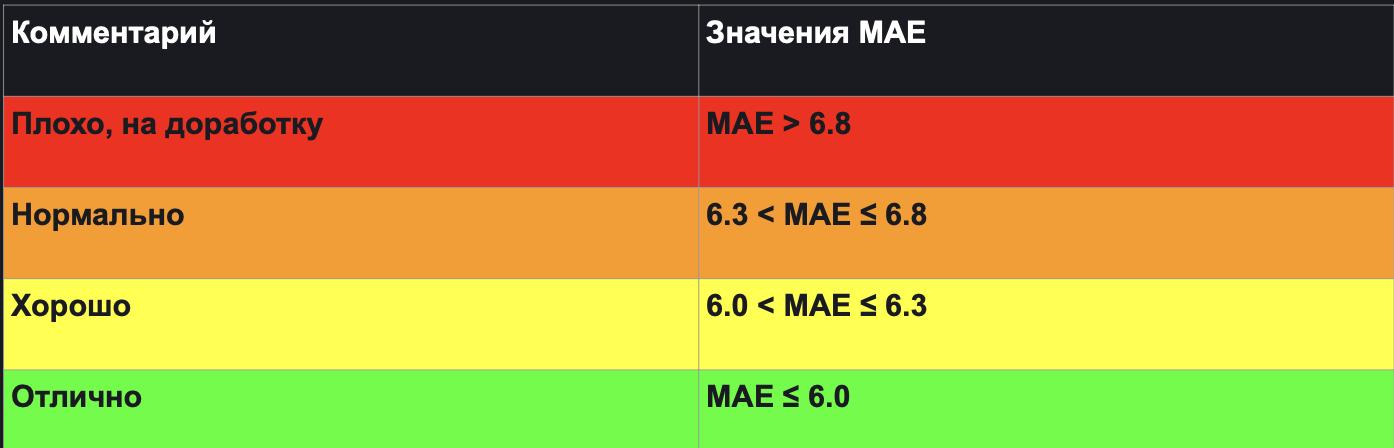

**Посмотрим важность признаков:**

Постройка значения на основе дерева (или Джини):

Text(0.5, 1.0, 'Feature Importance')

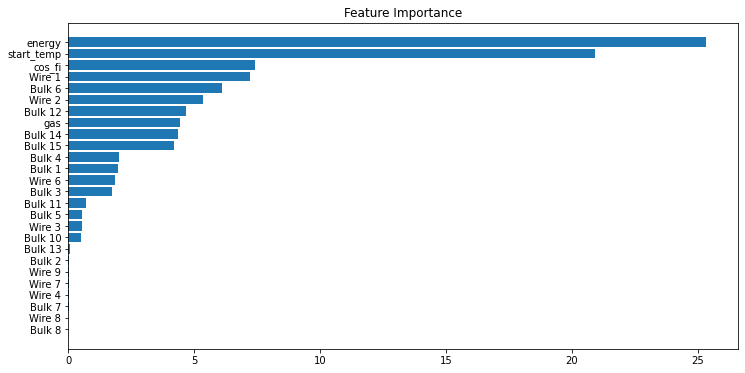

In [108]:
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')

Постройка значений перестановок:

Text(0.5, 1.0, 'Permutation Importance')

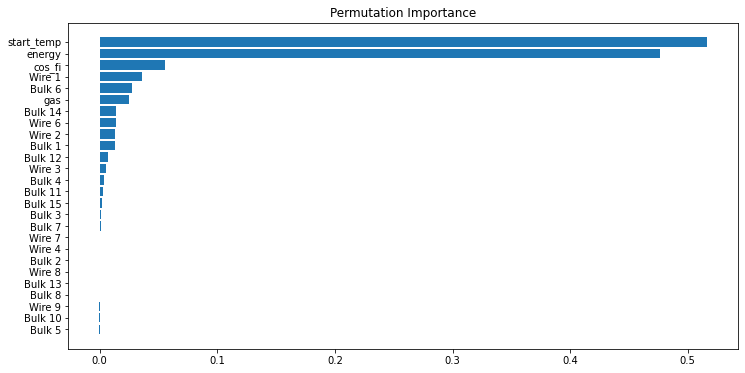

In [110]:
perm_importance = permutation_importance(cb, features_test, target_test, n_repeats=10, random_state=RANDOM_STATE)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Permutation Importance')

Постройка среднего абсолютного значения значений SHAP:

In [ ]:
explainer = shap.Explainer(cb)
shap_values = explainer(features_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('SHAP Importance')

SHAP содержит функцию для построения:

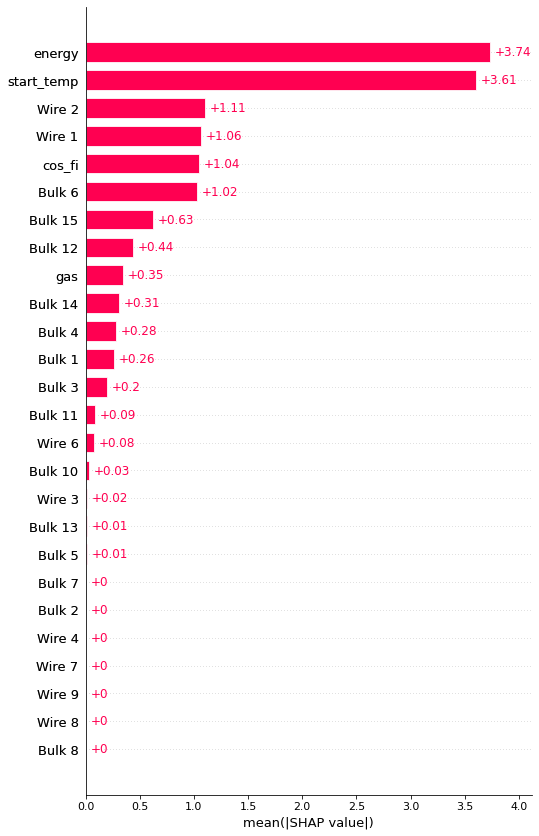

In [112]:
shap.plots.bar(shap_values, max_display=features_test.shape[0])

**Выделим топ 5 важных признаков:**

 1. energy - полная энергия.
 2. stat_temp - начальная темперарута.
 3. Wire 2 - проволочный материал 2.
 4. Wire 1 - проволочный материал 1.
 5. cos_fi - косинус фи.

## ОТЧЁТ ПО ПРОЕКТУ

**ПЕРВАЯ ЧАСТЬ ПРОЕКТА:**

Было проведено исследование и предобработка всех предоставленных датасетов.
По результатам исследования было выявлено и выполнено следующее:
1. По данным о работе электродов было расчитано время каждого нагрева.
2. На основе полученных данных о времени нагрева и зафиксрованных мощностей была посчитана потребленная электроэнергия в [КВА/ч].
3. Потребленная электроэнергия была сгруппирована на имеющеся партии (всего их 3214), что позволило нам получить  признак для наших моделей. Так же мы вычилисли новый признак - косинус фи.
4. Мы изучили данные о сыпучих и проволочных материалах. Было выявлено множество пропусков, что указывает на то, что данные материалы не добавлялись в текущую партию - пропуски в датасетах с объемами были заменены на 0.
5. Мы проанализировали данные по времени добавления присадок. Выявлена аналогия структы данных по объемам. Был сделан вывод, что использование данных со временем не требуется, т.к. в рамках проекта не решается задача временных рядов.
6. Мы проанализировали данные о добавлении газа. Данные имеют нормальное распределение и имеются практически для всех партий, содержащихся в датасете (3239 партий).
7. Мы проанализировали измеренные в ходе технологического процесса температуры, в результате чего выявлены явные выбросы ниже 1500 градусов, а также ряд партий с всего 1 измерением. По информации от заказчика такие партии должны быть исключены из проекта.
8. Все значения температур были сгруппированы по партиям. В качестве одного из обучающих признаков взято первое измеренное значение температуры, а в качестве таргета - последнее измеренное значение.
9. В качестве завершающего этапа по предобработке данных все датасеты были объединены в один общий. Партии в которых есть данные о температуре, но имеются пропуски в других данных - были исключены.

**ВТОРАЯ ЧАСТЬ ПРОЕКТА:**

Была проведена подготовка выборок и дальнейшее обучение моделей:
1. Была выявлена сильная взаимосвязь между признаками Bulk 9 и Wire 8 (коэффициент корреляции равен 0.974969), поэтому один из признаков (Bulk 9) был удален из датасета.
2. Также  из общего датасета исключены данные по партиям и количеству замеров по температуре.
3. Для всех моделей был применен поиск оптимальных параметров с помощью GridSearchCV и кросс-валидации с 5 фолдами.
4. Была обучена модель линейной регрессии: получен MAE=6.927 с параметрами fit_intercept': True, 'normalize': True. Данная модель превысела допустимый заказчиком порог МАЕ в 6.8.
5. Была обучена модель случайного леса: получен MAE=6.289 с параметрами max_depth : 10, 'n_estimators' : 80. Данная модель вошла в допустимый заказчиком порог МАЕ в 6.8.
6. Была обучена модель LightGBM: получен MAE=6.176 с параметрами 'learning_rate': 0.04, 'n_estimators': 100, 'num_leaves': 21. Данная модель вошла в допустимый заказчиком порог МАЕ в 6.8.
7. Была обучена модель CatBoost: получен МАЕ=6.130 с параметрами 'iterations': 500, 'learning_rate': 0.03. Данная модель вошла в допустимый заказчиком порог МАЕ в 6.8.

**ТРЕТЬЯ ЧАСТЬ ПРОЕКТА:**

На тестовой выборке лучшая модель CatBoostRegressor успешно преодолели минимальное установленное значение MAE в 6.8 и проверенная с помощью DummyRegressor. Так же мы выделили топ 5 важных признаков. Мы получили значение MAE 5.66 на тетовой выборке с подобранными гиперпараметрами iterations = 500 и learning_rate = 0.03. Именно данную модель мы рекомендуем заказчику в качестве решения поставленной задачи.